In [10]:
# import libraries

# for scraping
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import requests
import time

# for parsing
from datetime import datetime

# for plotting
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar
from matplotlib.ticker import MaxNLocator

In [11]:
# decide whether to use old data or scrape new
use_existing_csv = False
csv_file_name = 'steam_top_seller_data_06-01-2024_20-31-48.csv'

In [12]:
# get urls from steam top sellers
if not use_existing_csv:
    # get urls for top sellers (in order)
    browser = webdriver.Chrome()
    browser.get('https://store.steampowered.com/search/?sort_by=_ASC&filter=topsellers&os=win&supportedlang=english&ignore_preferences=1')
    elem = browser.find_element(By.TAG_NAME, 'body')
    pagedowns = 100
    
    for i in range(pagedowns):
        elem.send_keys(Keys.PAGE_DOWN)
        time.sleep(0.2)
    
    elems = browser.find_elements(By.CLASS_NAME, 'search_result_row')
    
    urls = []
    
    for elem in elems:
        urls.append(elem.get_attribute('href'))
    
    browser.close()
        
    print(f'{len(urls)} urls scraped from steam windows top sellers')

In [13]:
# create soup from each url
if not use_existing_csv:
    
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.108 Safari/537.36',
        'Accept-Encoding':'gzip, deflate',
        'Accept':'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
        'DNT':'1',
        'Connection':'close',
        'Upgrade-Insecure-Requests':'1'
    }
    
    cookies = {
        'lastagecheckage': '1-0-1990',
        'birthtime': '691567000'
    }

    # start session
    session = requests.Session()
    session.cookies.update(cookies)

    # get data for each top seller
    top_seller_soups = []
    
    for i in range(len(urls)):
        url = urls[i]
        
        res = session.get(url, headers=headers)
        
        soup = BeautifulSoup(res.content, 'html.parser')
    
        top_seller_soups.append(soup)
    
        print(f'{i}/{len(urls) - 1} complete', end='\r')

In [14]:
# define helper functions
# convert steam date to datetime object
def interpret_steam_date(date_str: str) -> datetime:
    # format: Oct 6, 2020
    try:
        return datetime.strptime(date_str, "%b %d, %Y")
    except:
        try:
            # may not have day: Apr 2019
            return datetime.strptime(date_str, "%b %Y")
        except:
            # release date is only an estimate/does not match format
            return None

In [15]:
# parse data
if not use_existing_csv:    
    # set up data object
    data = {
        'title': [],
        'developers': [],
        'publishers': [],
        'release_date': [],
        'header_img': [],
        'genres': [],
        'franchise': [],
        'early_access_length': [],
        'metacritic_score': [],
        'price': []
    }
    
    # format data
    for i in range(len(top_seller_soups)):
        soup = top_seller_soups[i]
    
        # game title
        try:
            title = soup.find('div', {'id':'appHubAppName'}).get_text()
    
            root_breadcrumb = soup.find('div', {'class': 'breadcrumbs'}).find('a').get_text().strip()

            # ignore everything that is not a game
            if 'games'.casefold() in root_breadcrumb.casefold():
                data['title'].append(title)
            else:
                continue
        except AttributeError:
            # no game title
            continue
            
        # developer and publisher
        dev_pub_info = soup.find('div', {'id': 'game_highlights'}).find_all('div', {'class': 'dev_row'})
    
        existence_check = {
            'developers': False,
            'publishers': False
        }
        
        for div in dev_pub_info:
            key = div.find('div', {'class': 'subtitle column'}).get_text().replace(':', '').lower() + 's'
            existence_check[key] = True
            
            names_soup = div.find('div', {'class': 'summary column'}).find_all('a')
            names = ''
    
            for name in names_soup:
                names += name.get_text() + ';'
            
            data[key].append(names)
    
        # if dev or publisher info wasn't found, fill in
        for key in existence_check:
            if not existence_check[key]:
                data[key].append('')
    
        # header image
        image_soup = soup.find('img', {'class': 'game_header_image_full'})
    
        image = image_soup['src'] if image_soup else None
        data['header_img'].append(image)
    
        # get div for genres, franchise, early access
        genres_manufacturer_soup = soup.find('div', {'id': 'genresAndManufacturer'})
        
        # genres
        genres_parent = genres_manufacturer_soup.find('span')
    
        genres = ''
    
        if genres_parent:
            genres_soup = genres_parent.find_all('a')
        
            for genre in genres_soup:
                genres += genre.get_text() + ';'

        data['genres'].append(genres)
        
        # franchise
        dev_rows = genres_manufacturer_soup.find_all('div', {'class': 'dev_row'})
        has_franchise = False
    
        for div in dev_rows:
            # franchise
            if div.find('b').get_text() == 'Franchise:':
                data['franchise'].append(div.find('a').get_text())
                has_franchise = True
    
        if not has_franchise:
            data['franchise'].append('')
    
        # release date
        release_date_soup = soup.find('div', {'class': 'date'})
        
        release_date = release_date_soup.get_text() if release_date_soup else None
        if release_date:
            release_date = interpret_steam_date(release_date)
        data['release_date'].append(release_date)

        # early access
        early_access = [x for x in genres_manufacturer_soup.find_all('b') if x.get_text() == 'Early Access Release Date:']
    
        if len(early_access) == 1:
            early_access_str = early_access[0].next_sibling.get_text().strip()
    
            # find days between early access and release date
            early_access_dt = interpret_steam_date(early_access_str)
            days_between = (release_date - early_access_dt).days
            
            data['early_access_length'].append(days_between)
        else:
            data['early_access_length'].append(0)
    
        # metacritic
        metacritic_soup = soup.find('div', {'id': 'game_area_metascore'})
    
        # check if metacritic score exists
        if metacritic_soup is None:
            data['metacritic_score'].append('')
        else:
            score = metacritic_soup.find('div', {'class': 'score'}).get_text().strip()
            data['metacritic_score'].append(score)
    
        # non-sale price
        # get div for standard purchase (not demo, not bundle, etc)
        purchase_options = soup.find_all('div', {'class': 'game_area_purchase_game'})
    
        # no pricing info available
        if not purchase_options:
            data['price'].append(None)
        
        # if there is a demo, start looking for price at index 1
        start = 1 if soup.find('div', {'class': 'demo_above_purchase'}) else 0 
        
        for i in range(start, len(purchase_options)):
            purchase_div = purchase_options[i]
        
            # if on sale, price is in discount_original_price div, otherwise game_purchase_price div
            discount_original = purchase_div.find('div', {'class': 'discount_original_price'})
            game_purchase = purchase_div.find('div', {'class': 'game_purchase_price'})
    
            if discount_original:
                price = discount_original.get_text().strip()
            elif game_purchase:
                price = game_purchase.get_text().strip()
            else:
                # unable to read price
                if i == len(purchase_options) - 1:
                    # if we have gone through all of price_options, there is no standard price info available
                    data['price'].append(None)

                # check the next price option
                continue
                
            # add as float, set any form of free/free to play to 0
            formatted_price = 0 if 'free'.casefold() in price.casefold() else float(price[1:])
            data['price'].append(formatted_price)
    
            # stop looking
            break

    # save date/time for csv file name
    now = datetime.now()

In [16]:
# example of information gathered
if not use_existing_csv:
    idx = random.randint(0, len(data['title']) - 1)
    
    for property in data:
        print(f'{property.capitalize()}: {data[property][idx]}')

In [17]:
# helper function for converting to dataframe
def string_to_list(string: str, separator: str=None) -> list:
    if not pd.isna(string):
        split_str = string.split(separator)

        # make sure there are no empty strings
        return [x for x in split_str if x]
    else:
        return []

In [18]:
# convert to pandas data frame
steam_df = pd.read_csv(csv_file_name, header=0, parse_dates=[3], date_format='%Y-%m-%d') if use_existing_csv else pd.DataFrame(data)

# save as csv for later or external use
if not use_existing_csv:
    
    steam_df.to_csv(f'steam_top_seller_data_{now.strftime("%d-%m-%Y_%H-%M-%S")}.csv', index=False, date_format='%Y-%m-%d')

# convert developer, publisher, and genre strings to lists
steam_df['publishers'] = steam_df['publishers'].apply(string_to_list, separator=';')
steam_df['developers'] = steam_df['developers'].apply(string_to_list, separator=';')
steam_df['genres'] = steam_df['genres'].apply(string_to_list, separator=';')


# top 10
top_10 = steam_df.iloc[:10]

# top 100
top_100 = steam_df.iloc[:100]

# top 1000
top_1000 = steam_df.iloc[:1000]
steam_df.head()

,title,developers,publishers,release_date,header_img,genres,franchise,early_access_length,metacritic_score,price
0,Baldur's Gate 3,[Larian Studios],[Larian Studios],2023-08-03,https://cdn.cloudflare.steamstatic.com/steam/a...,"[Adventure, RPG, Strategy]",Baldur's Gate,1031,96.0,59.99
1,Lethal Company,[Zeekerss],[Zeekerss],2023-10-23,https://cdn.cloudflare.steamstatic.com/steam/a...,"[Action, Adventure, Indie, Early Access]",NaN,0,NaN,9.99
2,Counter-Strike 2,[Valve],[Valve],2012-08-21,https://cdn.cloudflare.steamstatic.com/steam/a...,"[Action, Free to Play]",NaN,0,NaN,0.00
3,Call of Duty®,"[Infinity Ward, Raven Software, Beenox, Treyar...",[Activision],2022-10-27,https://cdn.cloudflare.steamstatic.com/steam/a...,[Action],Call of Duty,0,NaN,69.99
4,Ready or Not,[VOID Interactive],[VOID Interactive],2023-12-13,https://cdn.cloudflare.steamstatic.com/steam/a...,"[Action, Adventure, Indie]",NaN,726,NaN,49.99


In [32]:
# plot genre function
def plot_genres(df: pd.DataFrame, num_records: int):
    genre_totals = {}
    
    for genres in df['genres']:
        for genre in genres:
            if genre in genre_totals:
                genre_totals[genre] += 1
            else:
                genre_totals[genre] = 1
                
    # set colors to ensure different color for each genre + plot is readable
    colors = ['lightgray',
              'lightcoral',
              'sandybrown',
              'khaki',
              'darkkhaki',
              'yellowgreen',
              'aquamarine',
              'powderblue',
              'plum',
              'pink',
              'firebrick',
              'bisque',
              'springgreen',
              'slateblue']
        
    # plot
    plt.figure(figsize=(14, 8))

    explode = [0.05] * len(genre_totals.keys())
    plt.pie(genre_totals.values(), explode=explode, autopct='%1.1f%%', colors=colors)
    
    plt.legend(labels=genre_totals.keys(), loc='center right', bbox_to_anchor=(1.4, 0.5))
    plt.title(f'Genre Breakdown - Steam Top {num_records} Windows Games')

    # save graph as image
    plt.savefig(f'graph_images/genres_top_{num_records}.png')

    # display graph
    plt.show()
    


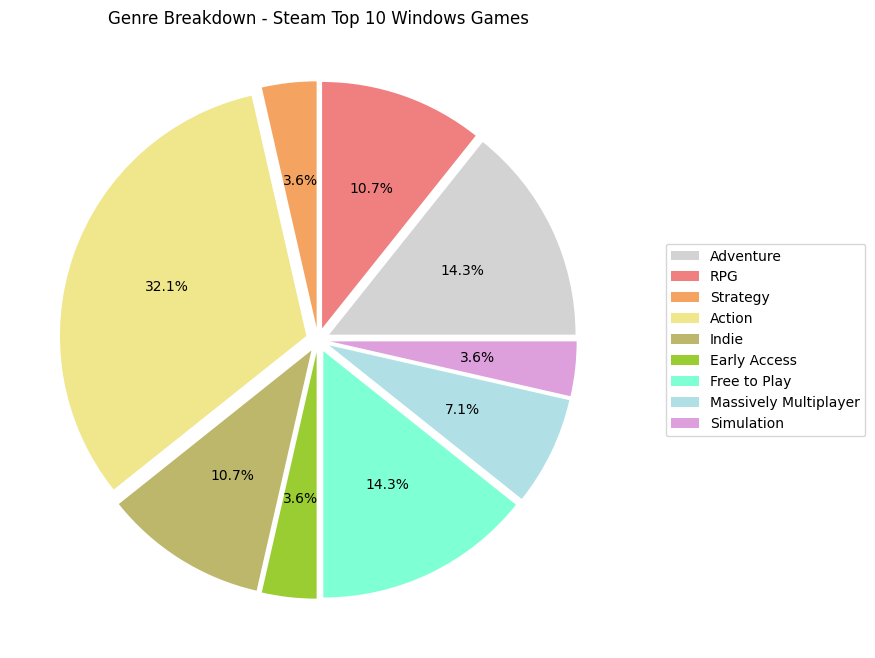

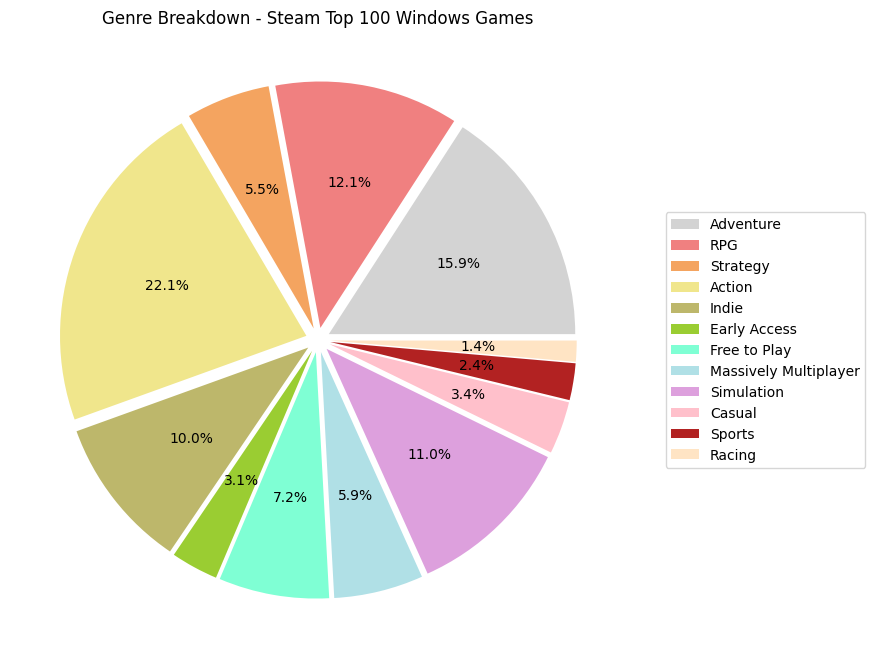

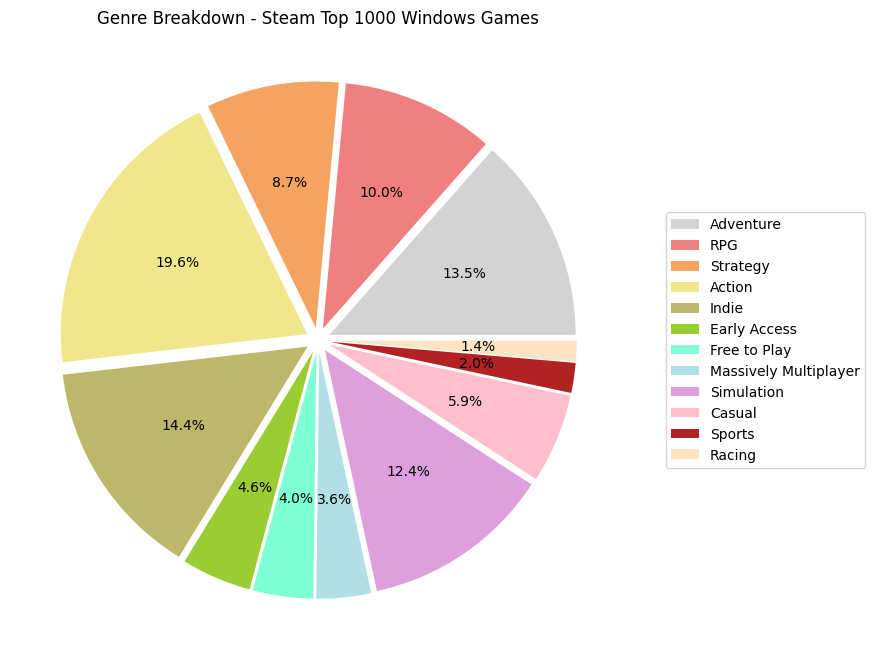

In [33]:
plot_genres(top_10, 10)
plot_genres(top_100, 100)
plot_genres(top_1000, 1000)

In [34]:
# plot year
def plot_years(df: pd.DataFrame, num_records: int):
    release_years = {}
    
    # count titles for each year
    for i in range(len(df['release_date'])):
        release_date = df['release_date'][i]
        year = release_date.year

        if year in release_years:
            release_years[year] += 1
        else:
            release_years[year] = 1

    # plot
    plt.figure(figsize=(14, 3))
    
    plt.bar(release_years.keys(), release_years.values())
    
    # show every year between earliest and latest year
    earliest_yr = min(release_years.keys())
    latest_yr = max(release_years.keys())
    plt.xticks(np.arange(earliest_yr, latest_yr + 1, step=1))

    # force y ticks to be integers
    ax = plt.gca()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    plt.title(f'Release Years - Steam Top {num_records} Windows Games')
    plt.xlabel('Release Year')
    plt.ylabel('Number of Titles')

    # save graph as image
    plt.savefig(f'graph_images/release_years_top_{num_records}.png')

    # display graph
    plt.show()

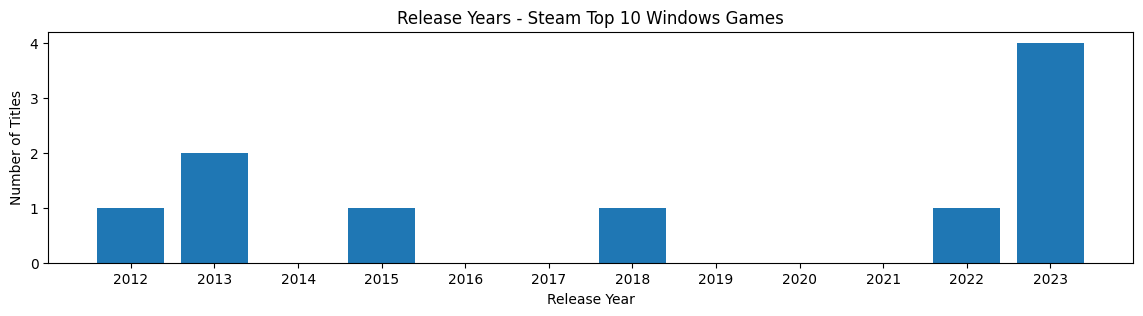

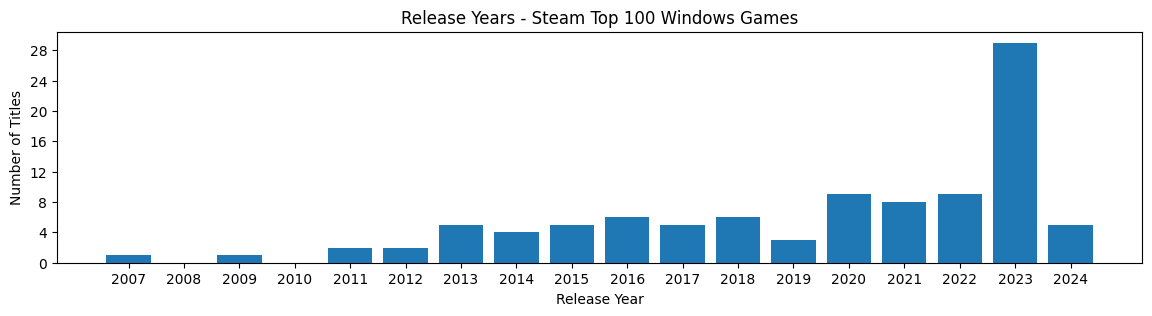

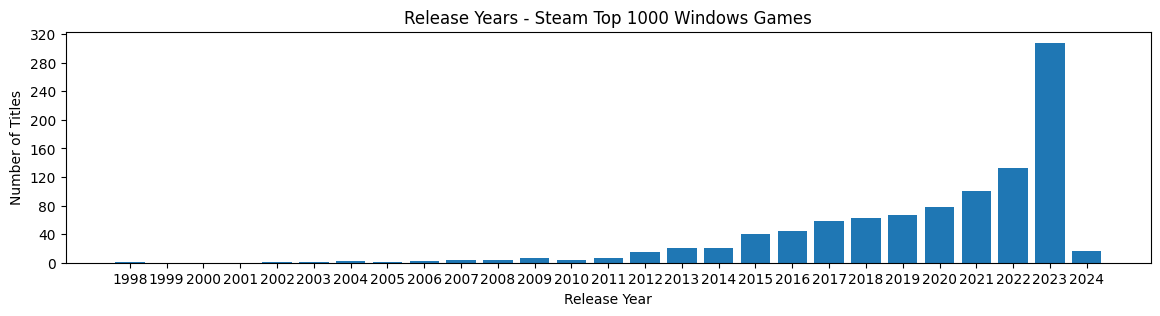

In [35]:
plot_years(top_10, 10)
plot_years(top_100, 100)
plot_years(top_1000, 1000)

In [36]:
# plot months
def plot_months(df: pd.DataFrame, num_records: int):
    release_months = {}
    
    for i in range(1, 13):
        release_months[calendar.month_abbr[i]] = 0

    # count titles for each month
    for i in range(len(df['release_date'])):
        release_date = df['release_date'][i]
    
        month = release_date.month

        # make sure there is a month
        if not pd.isna(month):
            key = calendar.month_abbr[month]
            release_months[key] += 1
    
    # months
    plt.figure(figsize=(10, 3))
    
    plt.bar(release_months.keys(), release_months.values())

    # force y ticks to be integers
    ax = plt.gca()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    plt.title(f'Release Months - Steam Top {num_records} Windows Games')
    plt.xlabel('Release Month')
    plt.ylabel('Number of Titles')
    
    # save graph as image
    plt.savefig(f'graph_images/release_months_top_{num_records}.png')

    # display graph
    plt.show()

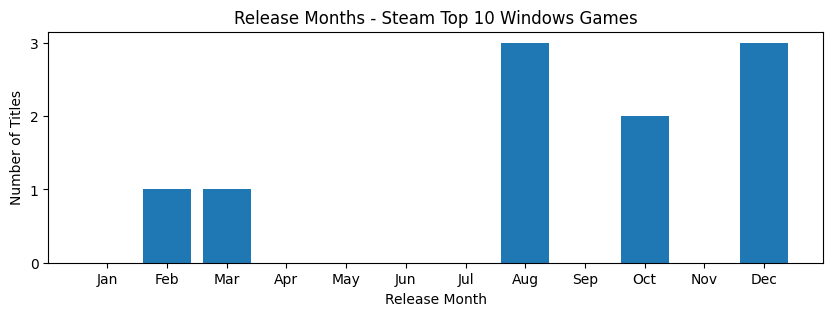

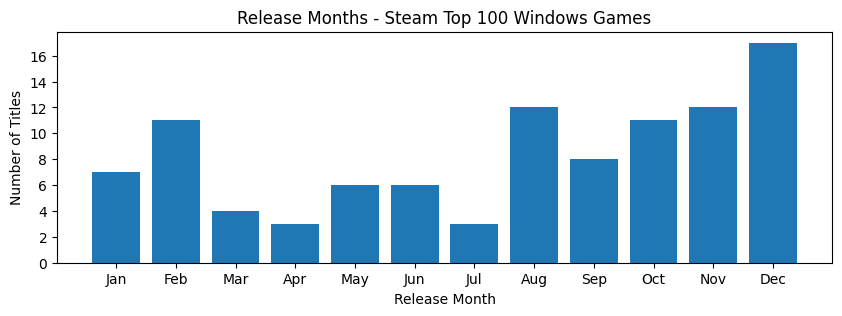

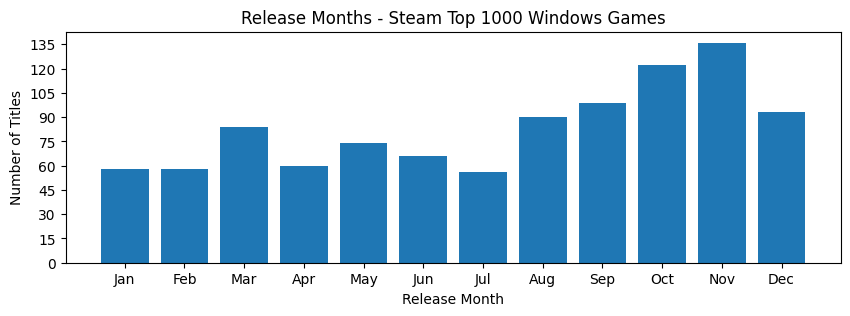

In [37]:
plot_months(top_10, 10)
plot_months(top_100, 100)
plot_months(top_1000, 1000)

In [38]:
# prices (top 100)
def plot_prices(df: pd.DataFrame, num_records: int):
    plt.figure(figsize=(16, 5))

    # free to play, then 0.01 - 9.99, 10-19.99, 20-29.99, etc
    bin_markers = np.arange(0, 70, 10)
    bins = [f'\${x}.01 - \${x+9}.99' for x in bin_markers]
    bins.insert(0, 'Free to Play')
    bins.append('$70 or over')

    y = [0] * len(bins)

    # sort prices
    for price in df['price']:
        if price == 0:
            # if price == 0, game is free to play
            y[0] += 1
        else:
            # iterate backwards to account for all prices $70 and above
            for i in range(len(bin_markers) - 1, -1, -1):
                if price > bin_markers[i]:
                    y[i + 1] += 1
                    break

    plt.bar(bins, y)

    # force y ticks to be integers
    ax = plt.gca()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    plt.title(f'Standard Prices - Steam Top {num_records} Windows Games')
    plt.xlabel('Price')
    plt.ylabel('Number of Titles')

    # save graph as image
    plt.savefig(f'graph_images/prices_top_{num_records}.png')

    # display graph
    plt.show()

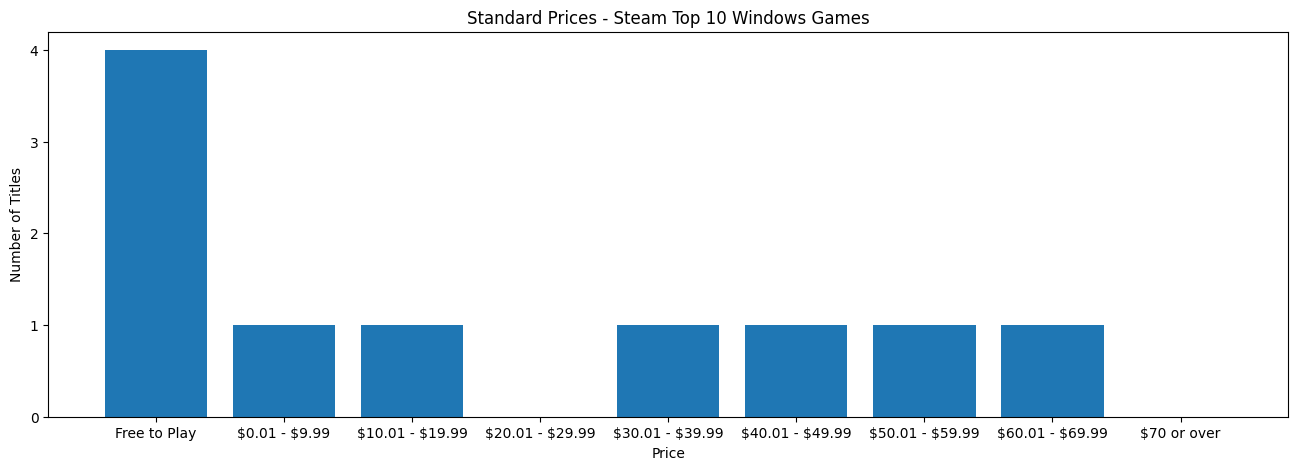

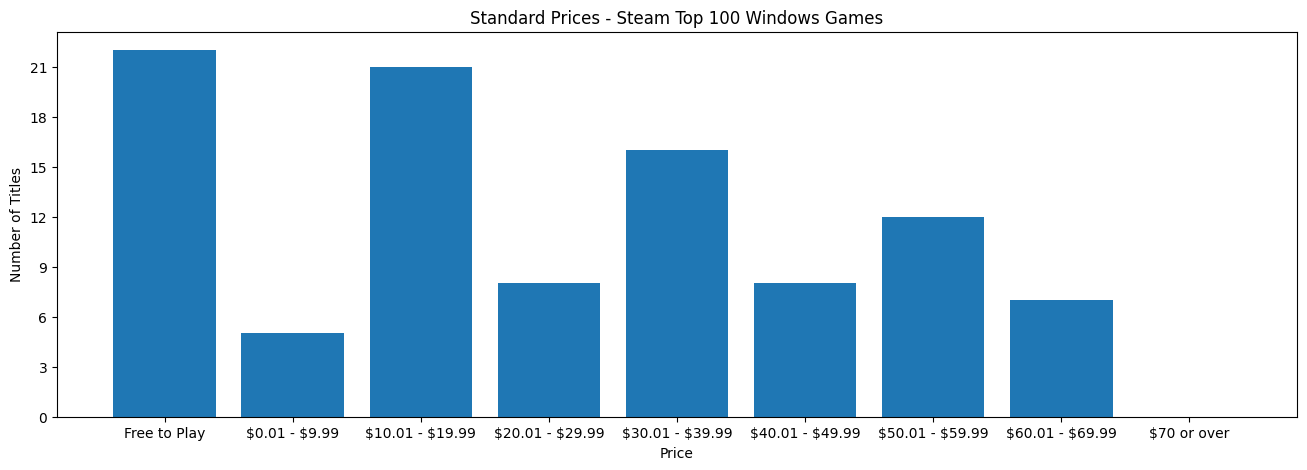

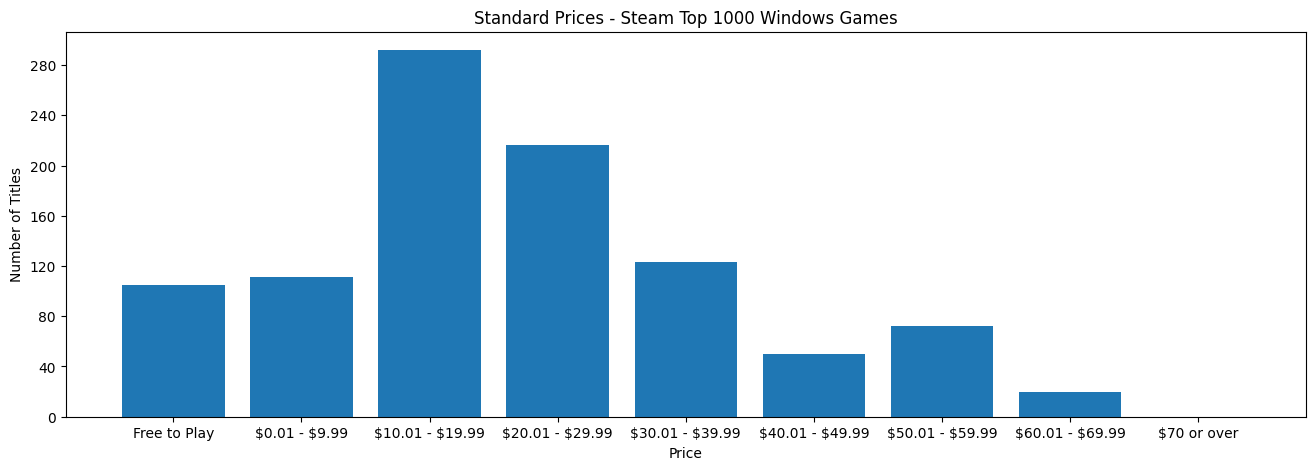

In [39]:
plot_prices(top_10, 10)
plot_prices(top_100, 100)
plot_prices(top_1000, 1000)